# A Simple Demo of AdaSTEM model using PydaSTEM package

Yangkang Chen<br>
Sep 4, 2023

In [5]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import geopandas as gpd
import os

# matplotlib.style.use('ggplot')
# plt.rcParams['axes.facecolor']='w'
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2

In [210]:
data = pd.read_csv(f'./BirdSTEM/dataset/test_data/Sample_data_Mallard.csv')


# Get X and y

In [266]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [313]:
from BirdSTEM.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                       Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                       random_state=42, test_size=0.3)


# Train AdaSTEM hurdle model

In [314]:
from BirdSTEM.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from BirdSTEM.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [315]:
model = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50)
)


In [316]:
model.fit(X_train.reset_index(drop=True), y_train)

training: 100%|██████████| 10930/10930 [07:24<00:00, 24.59it/s]


# Evaluation

In [317]:
pred = model.predict(X_test)


In [327]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 4.15%


In [319]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()


In [320]:
AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)


{'AUC': 0.6854553428094808,
 'kappa': 0.41973253939456423,
 'f1': 0.5001885843600704,
 'precision': 0.6028487006591409,
 'recall': 0.427405059891497,
 'average_precision': 0.3533474931387327,
 'Spearman_r': 0.4381358246901834,
 'Pearson_r': 0.1340902332617365,
 'R2': -0.1404361367608209,
 'MAE': 4.199485542686884,
 'MSE': 1360.8745083468675,
 'poisson_deviance_explained': 0.09225147285531843}

# Compare to simple Hurdle model

In [324]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
pred2 = model2.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.614874754867373,
 'kappa': 0.3024531192247014,
 'f1': 0.3682267387656163,
 'precision': 0.643005991143527,
 'recall': 0.25798191984114544,
 'average_precision': 0.288061783500689,
 'Spearman_r': 0.3520394407206567,
 'Pearson_r': 0.15540117044791554,
 'R2': -0.11859108757092018,
 'MAE': 3.99918310458487,
 'MSE': 1405.505184365956,
 'poisson_deviance_explained': 0.06904965429918242}

# Plot QuadTree ensembles

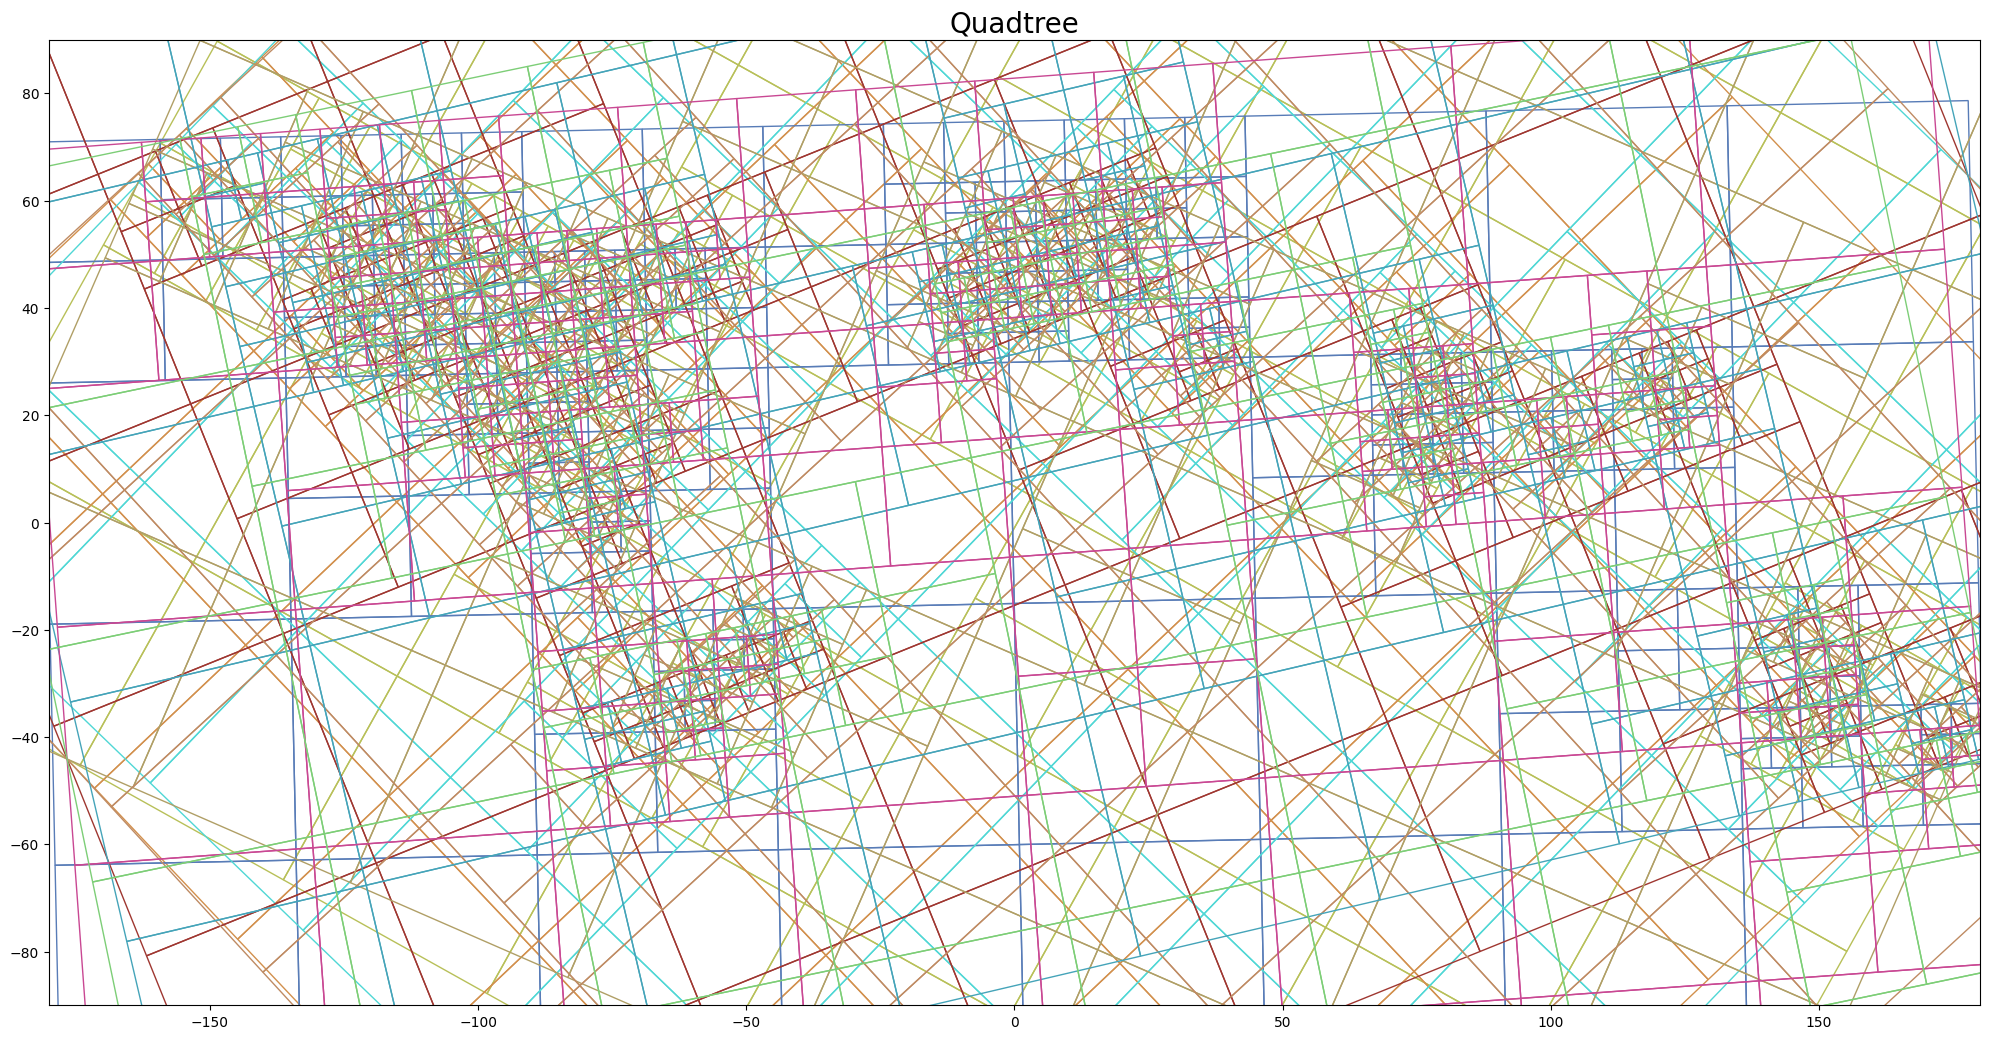

In [331]:
model.classifier.gridding_plot

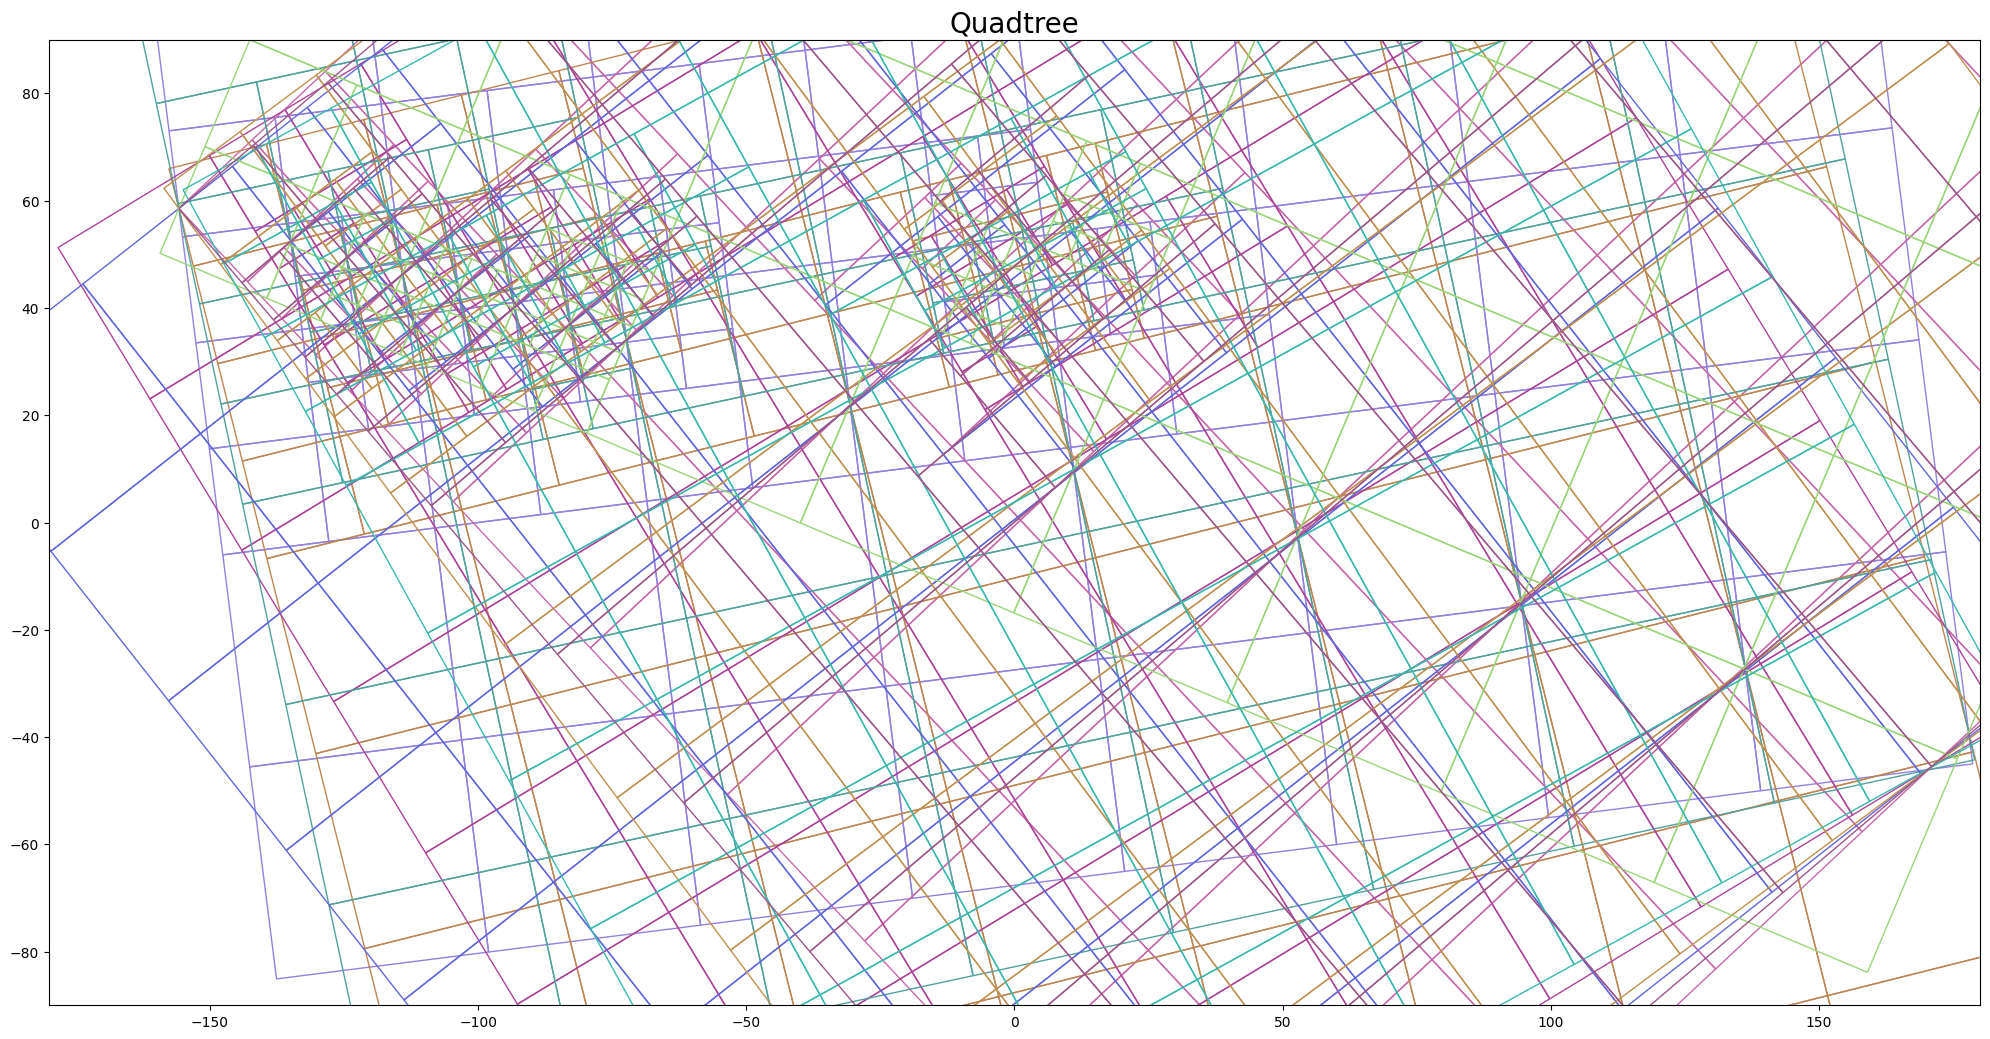

In [326]:
model.regressor.gridding_plot